In [2]:
# ==============================================================================
# CELLULE 1 : IMPORTATION DES LIBRAIRIES
# ==============================================================================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Librairies importées.")

✅ Librairies importées.


In [3]:
# ==============================================================================
# CELLULE 2 : CHARGEMENT ET PRÉPARATION DES DONNÉES
# ==============================================================================
print("\n--- Chargement et préparation des données ---")
try:
    df = pd.read_csv('df3.csv')
    print(f"Fichier df3.csv chargé avec succès : {df.shape[0]} lignes.")
except FileNotFoundError:
    print("ERREUR : Fichier 'df3.csv' non trouvé.")
    exit()

# Dictionnaire pour renommer les colonnes
columns_mapping = {
    'model1': 'make',
    'model2': 'model',
    'km': 'mileage',
    'fuel': 'fuel_type',
    'HorseP': 'engine_hp',
    'price': 'price',
    'year': 'year' # Assumant que 'year' existe, sinon supprimez cette ligne
}

# Vérifier si les colonnes existent avant de les utiliser
columns_to_use = [col for col in columns_mapping.keys() if col in df.columns]
df_selected = df[columns_to_use]
df_renamed = df_selected.rename(columns=columns_mapping)

# Nettoyage
df_clean = df_renamed.dropna()
df_clean = df_clean[df_clean['price'] > 100]
df_clean = df_clean[df_clean['mileage'] > 0]
print(f"Données après nettoyage : {df_clean.shape[0]} lignes.")
print("Colonnes utilisées pour le modèle :", list(df_clean.columns))


--- Chargement et préparation des données ---
Fichier df3.csv chargé avec succès : 141199 lignes.
Données après nettoyage : 140708 lignes.
Colonnes utilisées pour le modèle : ['make', 'model', 'mileage', 'fuel_type', 'engine_hp', 'price', 'year']


In [4]:
# ==============================================================================
# CELLULE 3 : ENCODAGE ET PRÉPARATION FINALE
# ==============================================================================
print("\n--- Encodage des données catégorielles ---")
categorical_features = ['make', 'model', 'fuel_type']
encoders = {}

for col in categorical_features:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col])
        encoders[col] = le

X = df_clean.drop('price', axis=1)
y = df_clean['price']
print("Données prêtes pour l'entraînement.")


--- Encodage des données catégorielles ---
Données prêtes pour l'entraînement.


In [5]:
import sys
!{sys.executable} -m pip install --upgrade xgboost

In [7]:
# ==============================================================================
# CELLULE 4 : ENTRAÎNEMENT DU MODÈLE XGBOOST (Version Corrigée)
# ==============================================================================
print("\n--- Entraînement du modèle XGBoost ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# --- ✅ CORRECTION CI-DESSOUS ---
# On ajoute l'argument eval_set pour que early_stopping_rounds fonctionne.
# Le modèle va s'entraîner sur (X_train, y_train) et vérifier sa performance sur (X_test, y_test).
model.fit(
    X_train, 
    y_train
)
print("✅ Modèle entraîné avec succès.")


--- Entraînement du modèle XGBoost ---
✅ Modèle entraîné avec succès.


In [16]:
# --- ✅ 5. SAUVEGARDE AVEC PICKLE (PARTIE AJOUTÉE) ---
import os
import pickle
print("\n--- Sauvegarde du modèle et des encodeurs ---")

# Chemin de sortie vers le dossier de votre API
output_dir = '../api/model'
# Création du dossier s'il n'existe pas
os.makedirs(output_dir, exist_ok=True)

# Sauvegarde de l'objet 'model' entraîné
with open(os.path.join(output_dir, 'car_price_model.pkl'), 'wb') as f:
    pickle.dump(model, f)

# Sauvegarde du dictionnaire 'encoders'
with open(os.path.join(output_dir, 'encoders.pkl'), 'wb') as f:
    pickle.dump(encoders, f)

print(f"✅ Fichiers 'car_price_model.pkl' et 'encoders.pkl' sauvegardés dans le dossier '{output_dir}'.")


--- Sauvegarde du modèle et des encodeurs ---
✅ Fichiers 'car_price_model.pkl' et 'encoders.pkl' sauvegardés dans le dossier '../api/model'.


In [8]:
# ==============================================================================
# CELLULE 5 : MÉTRIQUES DE PERFORMANCE
# ==============================================================================
print("\n--- Évaluation du modèle ---")
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📊 R² Score : {r2:.2f} (plus c'est proche de 1, meilleur c'est)")
print(f"📉 Erreur Absolue Moyenne (MAE) : {mae:,.0f} € (l'erreur moyenne de prédiction)")
print(f"📈 Racine de l'Erreur Quadratique Moyenne (RMSE) : {rmse:,.0f} €")


--- Évaluation du modèle ---
📊 R² Score : 0.98 (plus c'est proche de 1, meilleur c'est)
📉 Erreur Absolue Moyenne (MAE) : 3,053 € (l'erreur moyenne de prédiction)
📈 Racine de l'Erreur Quadratique Moyenne (RMSE) : 4,968 €


In [14]:
# --- ✅ SAUVEGARDE DES MÉTRIQUES ---
import os
metrics = {
    "r2_score": f"{r2:.2f}",
    "mae": f"{mae:,.0f} €",
    "rmse": f"{rmse:,.0f} €"
}
# On s'assure que le dossier de destination existe dans le frontend
output_dir = '../frontend/public/assets/results'
os.makedirs(output_dir, exist_ok=True)

import json
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

print(f"✅ Métriques sauvegardées dans '{output_dir}/metrics.json'")

✅ Métriques sauvegardées dans '../frontend/public/assets/results/metrics.json'



--- Génération des graphiques ---


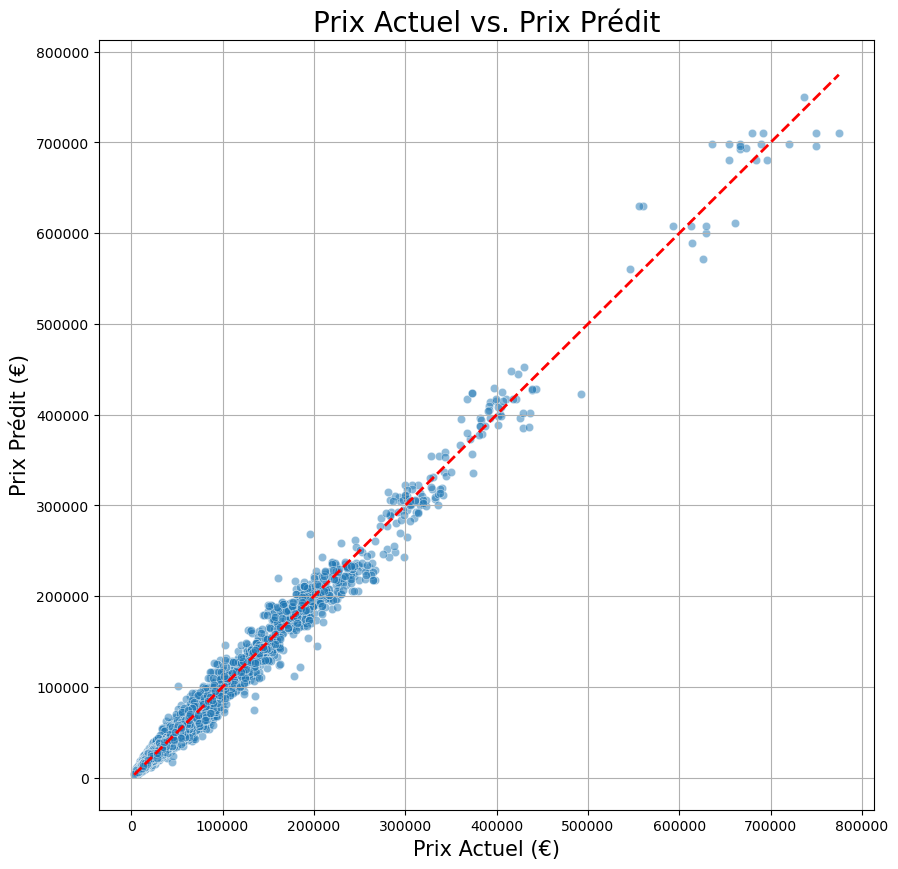

✅ Graphique 'actual_vs_predicted.png' sauvegardé.


In [ ]:
# ==============================================================================
# CELLULE 6 : GRAPHIQUE 1 - PRIX ACTUEL vs. PRIX PRÉDIT
# ==============================================================================
# Définition du dossier de sortie
output_dir_results = '../frontend/public/assets/img'
os.makedirs(output_dir_results, exist_ok=True)
print("\n--- Génération des graphiques ---")
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Prix Actuel vs. Prix Prédit', fontsize=20)
plt.xlabel('Prix Actuel (€)', fontsize=15)
plt.ylabel('Prix Prédit (€)', fontsize=15)
plt.grid(True)
# ✅ On sauvegarde AVANT d'afficher
plt.savefig(os.path.join(output_dir_results, 'actual_vs_predicted.png'))
plt.show() # On affiche après la sauvegarde
print("✅ Graphique 'actual_vs_predicted.png' sauvegardé.")

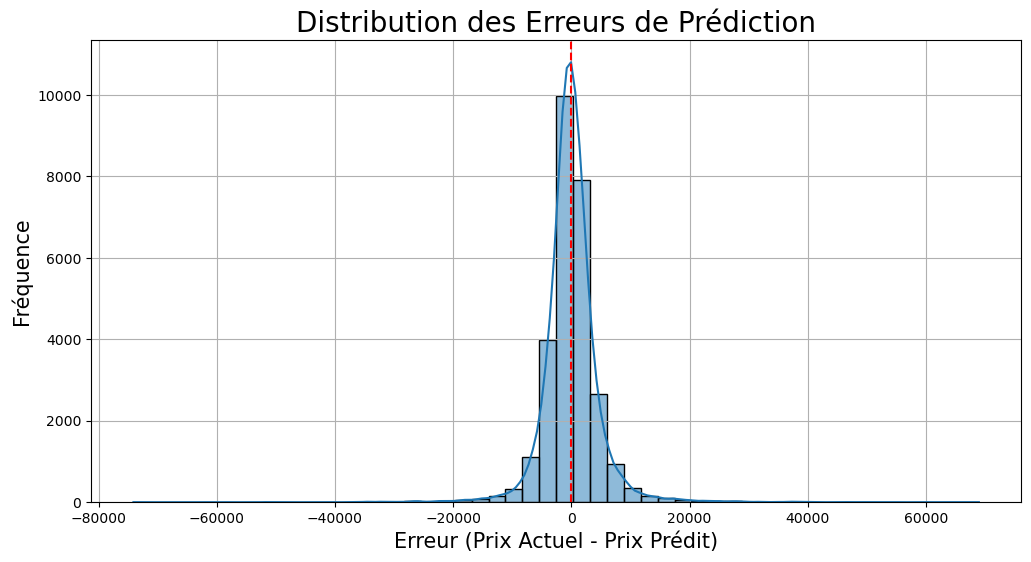

✅ Graphique 'errors_distribution.png' sauvegardé.


In [25]:
# ==============================================================================
# CELLULE 7 : GRAPHIQUE 2 - DISTRIBUTION DES ERREURS (RÉSIDUS)
# ==============================================================================
# Ce graphique aide à voir si le modèle fait des erreurs de manière systématique
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution des Erreurs de Prédiction', fontsize=20)
plt.xlabel('Erreur (Prix Actuel - Prix Prédit)', fontsize=15)
plt.ylabel('Fréquence', fontsize=15)
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
# ✅ On sauvegarde AVANT d'afficher
plt.savefig(os.path.join(output_dir_results, 'errors_distribution.png'))
plt.show() # On affiche après la sauvegarde
print("✅ Graphique 'errors_distribution.png' sauvegardé.")

C:\Users\novity\AppData\Local\Temp\ipykernel_24324\192851150.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')


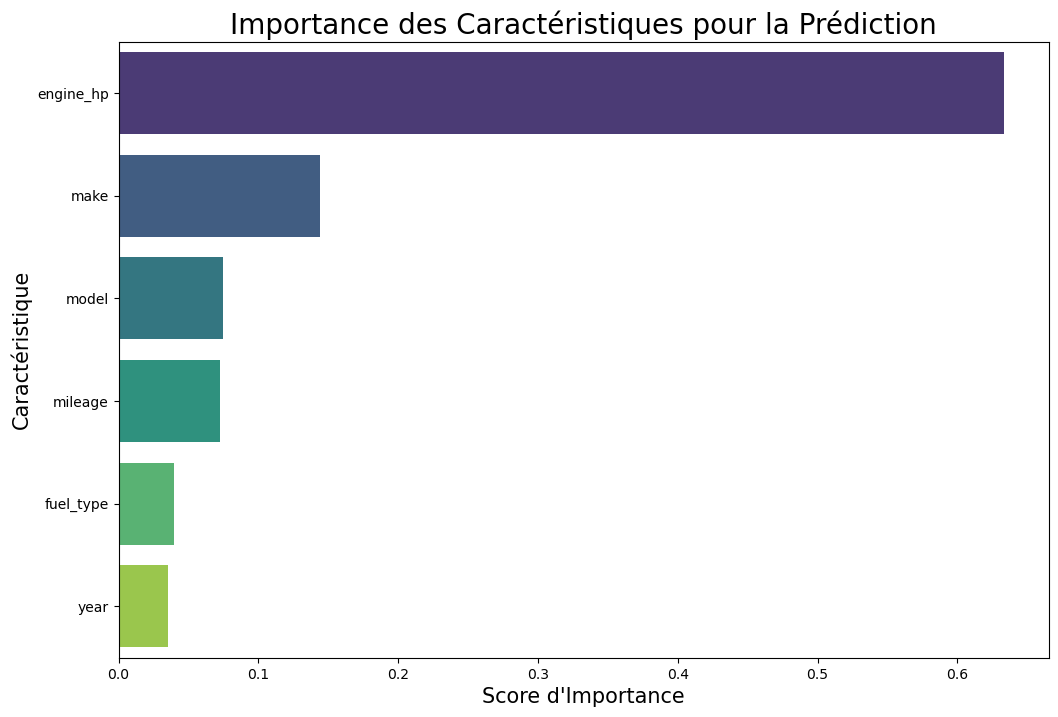

✅ Graphique 'errors_distribution.png' sauvegardé.


In [26]:
# ==============================================================================
# CELLULE 8 : GRAPHIQUE 3 - IMPORTANCE DES CARACTÉRISTIQUES
# ==============================================================================
# Ce graphique montre ce que le modèle considère comme important pour prédire le futur
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Importance des Caractéristiques pour la Prédiction', fontsize=20)
plt.xlabel('Score d\'Importance', fontsize=15)
plt.ylabel('Caractéristique', fontsize=15)
# ✅ On sauvegarde AVANT d'afficher
plt.savefig(os.path.join(output_dir_results, 'caracteristique_distribution.png'))
plt.show() # On affiche après la sauvegarde
print("✅ Graphique 'errors_distribution.png' sauvegardé.")